# **Domingo salida**

# Importación de _data_

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import fs
%matplotlib inline

In [2]:
from IPython.display import HTML

# Reading data

In [3]:
DATA_DIR = './data'
data_dir = fs.open_fs(DATA_DIR)
OUT_DIR = './out'
out_dir = fs.open_fs(OUT_DIR)

In [4]:
DATA_FILENAME= 'domingo - salida.xlsx'
data_dir.exists(DATA_FILENAME)
buffer = data_dir.openbin(DATA_FILENAME)

In [5]:
try:
    out_dir = out_dir.makedir(DATA_FILENAME)
except:
    out_dir = out_dir.opendir(DATA_FILENAME)

In [6]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
cmap = sns.color_palette(flatui, as_cmap=True)

# Rows

In [7]:
# rows
first_row = ['', 'moto', 'auto', 'station_wagon', '  ', 'camion']
second_row = ['bicicleta', 'moto_lineal', 'trimoto', 'moto_carga', 'particular', 'colectivo', 'taxi', 'particular', 'colectivo', 'taxi', 'miniban', 'microbus',  'camioneta','bus', 'tractores', '<12tn', '>12tn']
column_index = pd.MultiIndex.from_tuples([
    *zip( ((first_row[0] * 1, ) + (first_row[1], ) * 3 + (first_row[2], ) * 3 + (first_row[3], ) * 3 + (first_row[4], ) * 4 + (first_row[5], ) * 3), second_row )
])

In [8]:
data = pd.read_excel(buffer, index_col=0, sheet_name='Hoja1')
# data = data.dropna(data.index.isnull())
data = data[data.index.notnull()]
# data = data.set_index('Hora')
data.columns = column_index
hora = data.index.str.extract('^(\d?\d:\d\d)').astype('string').values
data.index = pd.Index(hora.ravel(), name='hora', dtype=str)
data.index = pd.to_datetime(data.index)
data = data.infer_objects()
data.to_excel(out_dir.getospath(path='data_original.xlsx').decode('utf-8'))
data.head()

moto                          auto  \
                    bicicleta moto_lineal trimoto moto_carga particular   
hora                                                                      
2022-10-06 06:00:00         0           4       0          0         24   
2022-10-06 06:15:00         0           2       1          1         18   
2022-10-06 06:30:00         0           4       4          0         31   
2022-10-06 06:45:00         0           2       2          0         15   
2022-10-06 07:00:00         0           2       0          0         11   

                                   station_wagon                         \
                    colectivo taxi    particular colectivo taxi miniban   
hora                                                                      
2022-10-06 06:00:00         0    5             5         0    0     5.0   
2022-10-06 06:15:00         0    3             5         0    1     0.0   
2022-10-06 06:30:00         0    5             2         0    1     2.0   
2022-10-06 06:45:00         0    4             6         0    0     1.0   
2022-10-06 07:00:00         0    9             2         0    3     4.0   

                                               camion              
                    microbus camioneta  bus tractores <12tn >12tn  
hora                                                               
2022-10-06 06:00:00      5.0       5.0  5.0       0.0    10     6  
2022-10-06 06:15:00      9.0       8.0  3.0       0.0     5     3  
2022-10-06 06:30:00      8.0       9.0  1.0       0.0     5     9  
2022-10-06 06:45:00      7.0       7.0  1.0       0.0     6     4  
2022-10-06 07:00:00     10.0       5.0  0.0       0.0     3     4

In [9]:
data.shape

(64, 17)

## Gráficas por tipo

In [10]:
period = '15T' # -> 15 minutos
data_resampled = data.resample(rule=period,label='right',closed='left').sum()

In [11]:
from time import strftime

_ = data_resampled.copy(deep=True)
_['hora'] = _.index.to_pydatetime()
_['hora'] = _['hora'].apply(lambda x: '{}'.format((x - pd.Timedelta('15T')).strftime('%H:%M')) + ' a ' + x.strftime('%H:%M'))
_.index.name = ""
# _.drop_index()
_.reset_index()
_ = _.set_index('hora')
_.to_excel(out_dir.getospath(path='data_resampled.xlsx').decode('utf-8'))

In [12]:
# from matplotlib.colors import ListedColormap
# cmap = ListedColormap(sns.color_palette('bright', 4))
cmap = 'Set1'

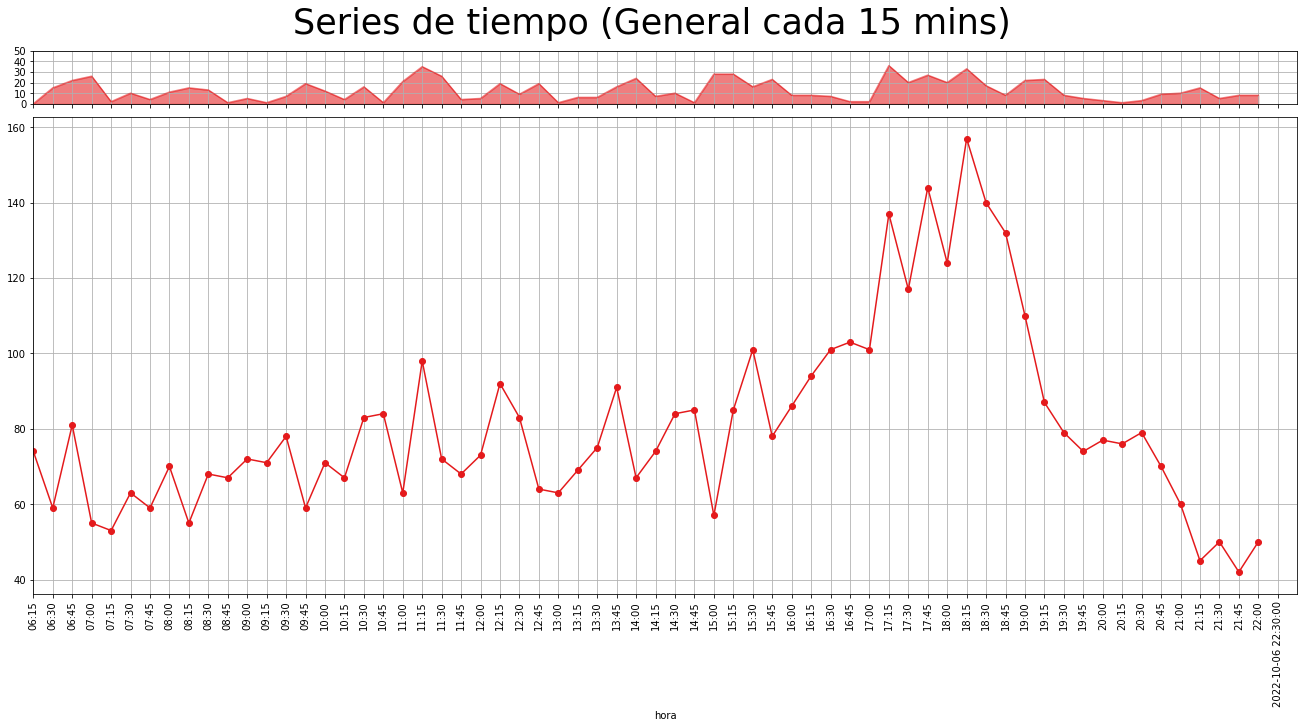

In [13]:
x_labels = data_resampled.index.astype('string').str.extract('(\d\d:\d\d):\d\d$').values.ravel().tolist()
x_ticks = pd.to_datetime(x_labels).tolist() 
x_ticks += [max(x_ticks) + pd.Timedelta(period)]
x_labels += [str(max(x_ticks) + pd.Timedelta(period))]
# x_labels += 'end'

fig, axes = plt.subplots(2, 1, figsize=(18,10), layout='constrained', sharex=True, gridspec_kw={'height_ratios': [1, 9]})
fig.suptitle("Series de tiempo (General cada 15 mins)", size=35)
data_resampled.sum(axis=1).diff().abs().plot(ax=axes[0],kind='area', alpha=.56, colormap=cmap, grid=True, yticks=[0,10,20,30,40,50])
data_resampled.sum(axis=1).plot(ax = axes[1], xticks=x_ticks,rot=90, grid=True, marker='o', colormap=cmap, xlim=(min(x_ticks), max(x_ticks) + pd.Timedelta(period)))
axes[0].set_xticklabels(x_labels)
fig.savefig(out_dir.getospath('series_de_tiempo_15.pdf').decode('utf-8'), format='pdf')
plt.show()

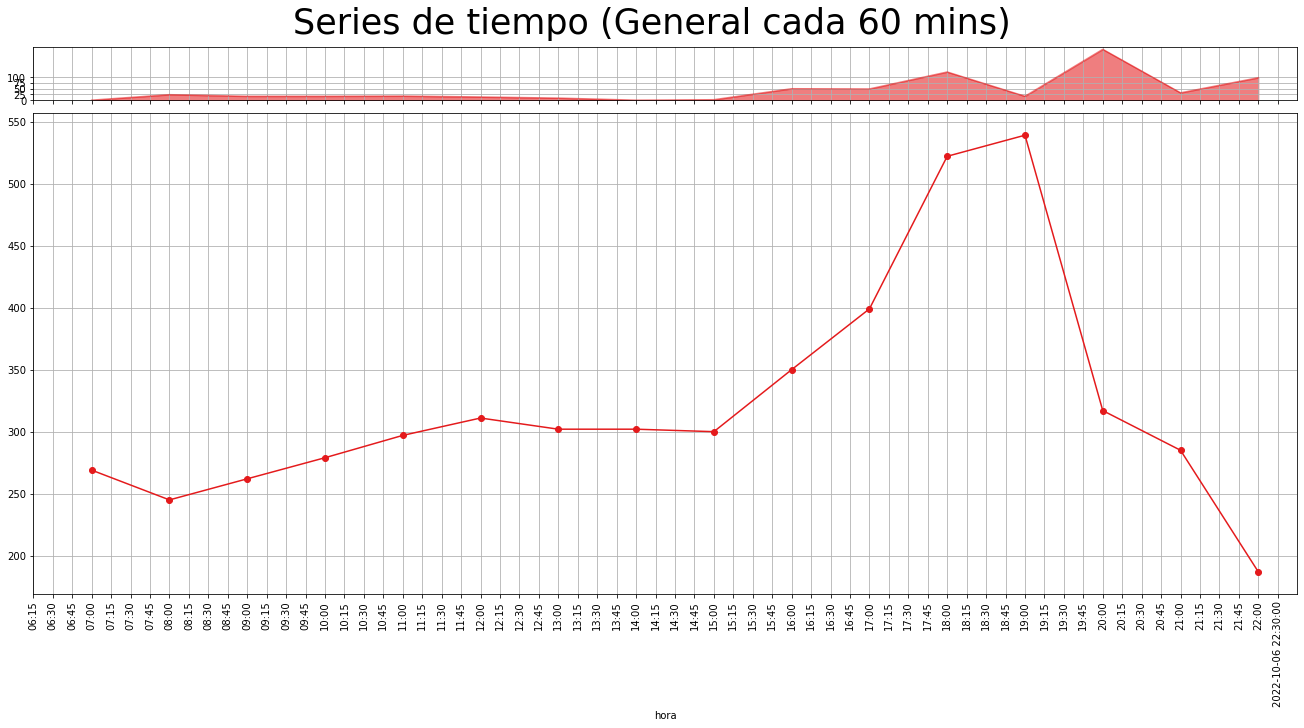

In [14]:
x_labels_ = data_resampled.index.astype('string').str.extract('(\d\d:\d\d):\d\d$').values.ravel().tolist()
x_ticks_ = pd.to_datetime(x_labels).tolist() 
period_ = '60T' # -> 15 minutos
data_resampled_ = data.resample(rule=period_,label='right',closed='left').sum()
fig, axes = plt.subplots(2, 1, figsize=(18,10), layout='constrained', sharex=True, gridspec_kw={'height_ratios': [1, 9]})
fig.suptitle("Series de tiempo (General cada 60 mins)", size=35)
data_resampled_.sum(axis=1).diff().abs().plot(ax=axes[0],kind='area', alpha=.56, colormap=cmap, grid=True, yticks=range(0,101,25))
data_resampled_.sum(axis=1).plot(ax = axes[1], xticks=x_ticks,rot=90, grid=True, marker='o', colormap=cmap, xlim=(min(x_ticks), max(x_ticks) + pd.Timedelta(period)))
axes[0].set_xticklabels(x_labels)
fig.savefig(out_dir.getospath('series_de_tiempo_15.pdf').decode('utf-8'), format='pdf')
plt.show()

In [15]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette('bright', 4))

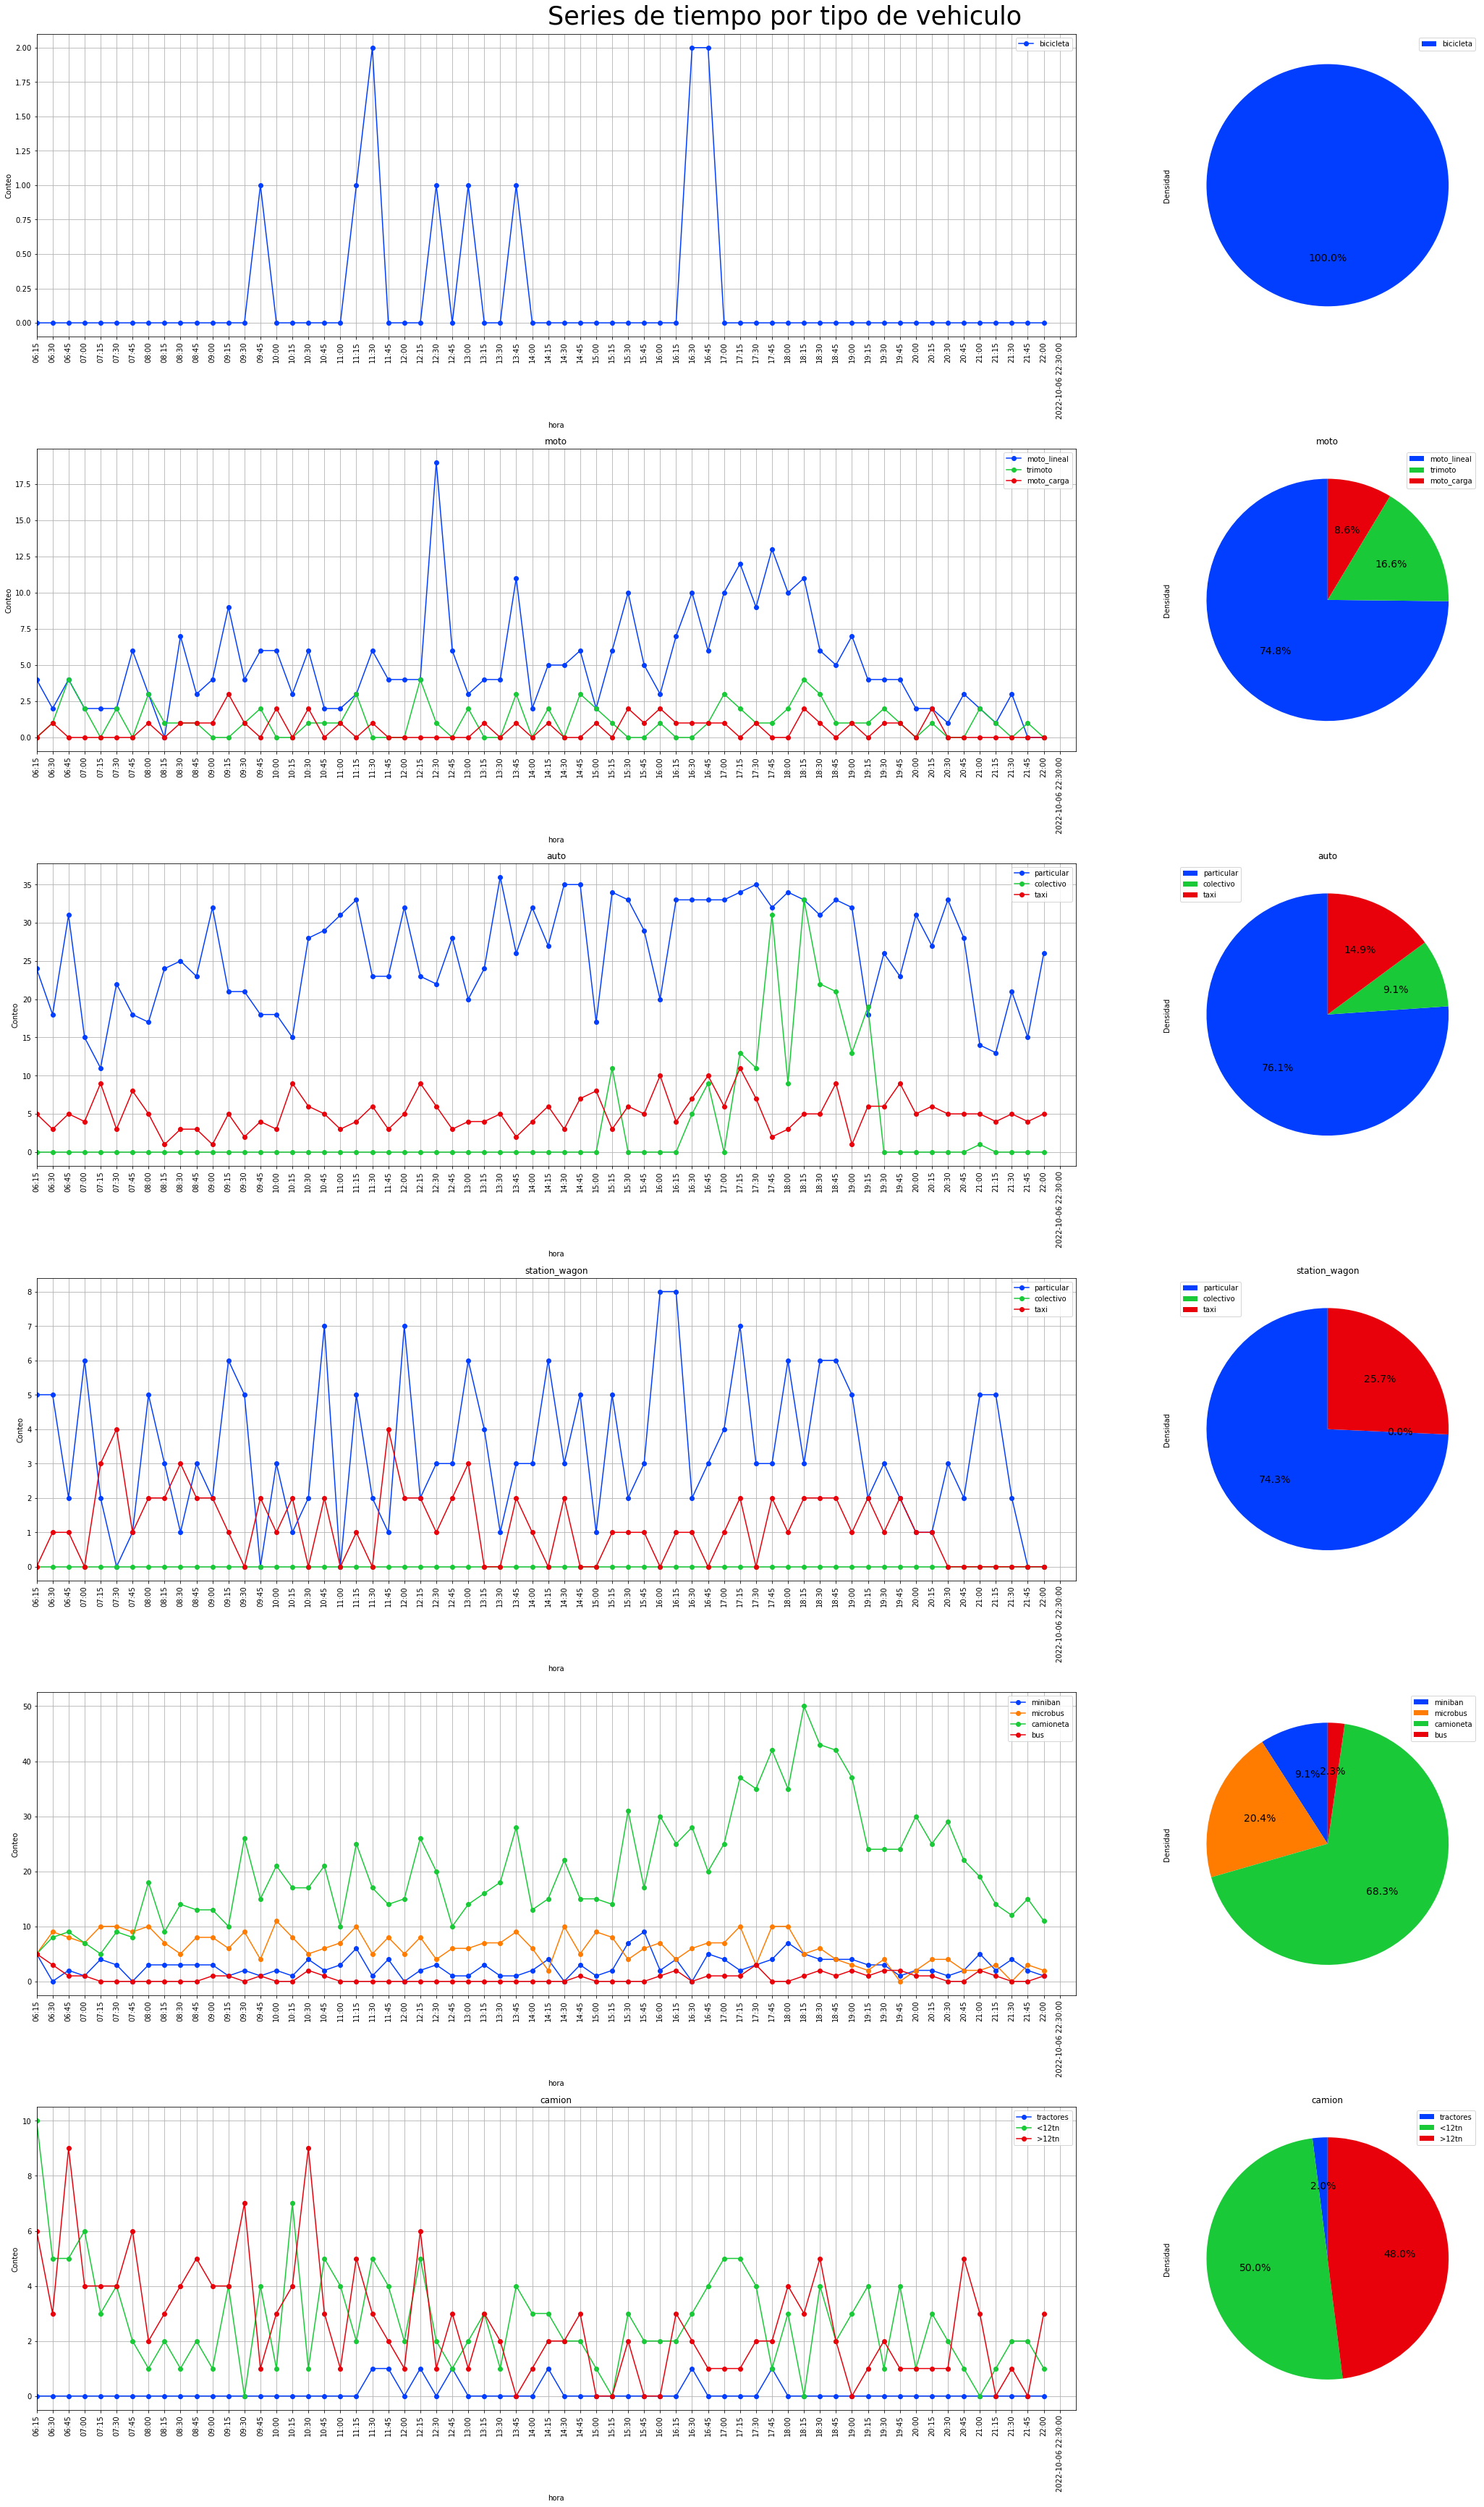

In [16]:
fig, axes = plt.subplots(len(first_row), 2, figsize=(30,48), gridspec_kw={'width_ratios': [2.2, 1],}, layout='constrained')
# fig.tight_layout()
fig.suptitle("Series de tiempo por tipo de vehiculo", size=35)
for ax, column_1 in zip(axes.reshape(-1,2), first_row):
    data_ = data_resampled[column_1]
    data_.plot(ax=ax[0], xticks=x_ticks,rot=90, grid=True, title=column_1, colormap=cmap, marker='o', xlim=(min(x_ticks), max(x_ticks) + pd.Timedelta(period)))
    ax[0].set_xticklabels(x_labels)
    ax[0].set_ylabel('Conteo')
    ax[1].set_title(column_1)
    data_.sum(axis=0).plot.pie(ax=ax[1], autopct='%1.1f%%', startangle=90, colormap=cmap, legend=True, labels=None, fontsize=14)
    ax[1].set_ylabel('Densidad')
# plt.xticks(ticks = data_resampled.index,labels=[str(i) for i in data_resampled.index])
fig.savefig(out_dir.getospath('series_por_tipo.pdf').decode('utf-8'), format='pdf')
plt.show()

# Valores estadísticos por tipo de carro

## Por tipo de carro

In [17]:
_ = data_resampled.describe()
_.to_excel(out_dir.getospath(path='resumen_1.xlsx').decode('utf-8'), sheet_name='por tipo de carro')
_

moto                             auto             \
       bicicleta moto_lineal    trimoto moto_carga particular  colectivo   
count  64.000000   64.000000  64.000000  64.000000  64.000000  64.000000   
mean    0.171875    5.015625   1.109375   0.578125  26.000000   3.093750   
std     0.489726    3.529882   1.156310   0.730399   6.794022   7.444437   
min     0.000000    0.000000   0.000000   0.000000  11.000000   0.000000   
25%     0.000000    2.750000   0.000000   0.000000  21.000000   0.000000   
50%     0.000000    4.000000   1.000000   0.000000  26.500000   0.000000   
75%     0.000000    6.000000   2.000000   1.000000  32.250000   0.000000   
max     2.000000   19.000000   4.000000   3.000000  36.000000  33.000000   

                 station_wagon                                             \
            taxi    particular colectivo       taxi    miniban   microbus   
count  64.000000     64.000000      64.0  64.000000  64.000000  64.000000   
mean    5.078125      3.343750       0.0   1.156250   2.703125   6.046875   
std     2.297719      2.124825       0.0   1.042262   1.822955   2.751217   
min     1.000000      0.000000       0.0   0.000000   0.000000   0.000000   
25%     3.000000      2.000000       0.0   0.000000   1.000000   4.000000   
50%     5.000000      3.000000       0.0   1.000000   2.500000   6.000000   
75%     6.000000      5.000000       0.0   2.000000   4.000000   8.000000   
max    11.000000      8.000000       0.0   4.000000   9.000000  11.000000   

                                camion                        
       camioneta        bus  tractores      <12tn      >12tn  
count  64.000000  64.000000  64.000000  64.000000  64.000000  
mean   20.281250   0.671875   0.109375   2.734375   2.625000  
std    10.104955   0.976789   0.314576   1.853715   2.081666  
min     5.000000   0.000000   0.000000   0.000000   0.000000  
25%    13.750000   0.000000   0.000000   1.000000   1.000000  
50%    17.500000   0.000000   0.000000   2.000000   2.000000  
75%    25.250000   1.000000   0.000000   4.000000   4.000000  
max    50.000000   5.000000   1.000000  10.000000   9.000000

## Por tipo carro (2)

In [18]:
_ = data_resampled.groupby(level=0, axis=1).sum().describe()
_.to_excel(out_dir.getospath(path='resumen_2.xlsx').decode('utf-8'), sheet_name='por tipo de vehiculo')
_

,,,auto,camion,moto,station_wagon
count,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000
mean,0.171875,29.703125,34.171875,5.468750,6.703125,4.500000
std,0.489726,10.933681,11.826195,3.023552,4.092888,2.281743
min,0.000000,15.000000,17.000000,0.000000,0.000000,0.000000
25%,0.000000,21.000000,26.000000,3.000000,4.000000,3.000000
50%,0.000000,26.500000,32.500000,5.000000,6.000000,4.500000
75%,0.000000,35.000000,38.250000,7.000000,8.250000,6.000000
max,2.000000,61.000000,71.000000,16.000000,20.000000,9.000000


## Por tipo de carro (3)

In [19]:
_ = data_resampled.groupby(level=1, axis=1).sum().describe()
_.to_excel(out_dir.getospath(path='resumen_3.xlsx').decode('utf-8'), sheet_name='completo')
_

,<12tn,>12tn,bicicleta,bus,camioneta,colectivo,microbus,miniban,moto_carga,moto_lineal,particular,taxi,tractores,trimoto
count,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000
mean,2.734375,2.625000,0.171875,0.671875,20.281250,3.093750,6.046875,2.703125,0.578125,5.015625,29.343750,6.234375,0.109375,1.109375
std,1.853715,2.081666,0.489726,0.976789,10.104955,7.444437,2.751217,1.822955,0.730399,3.529882,7.404886,2.395380,0.314576,1.156310
min,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000,2.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,13.750000,0.000000,4.000000,1.000000,0.000000,2.750000,24.750000,5.000000,0.000000,0.000000
50%,2.000000,2.000000,0.000000,0.000000,17.500000,0.000000,6.000000,2.500000,0.000000,4.000000,29.000000,6.000000,0.000000,1.000000
75%,4.000000,4.000000,0.000000,1.000000,25.250000,0.000000,8.000000,4.000000,1.000000,6.000000,36.000000,7.000000,0.000000,2.000000
max,10.000000,9.000000,2.000000,5.000000,50.000000,33.000000,11.000000,9.000000,3.000000,19.000000,41.000000,13.000000,1.000000,4.000000


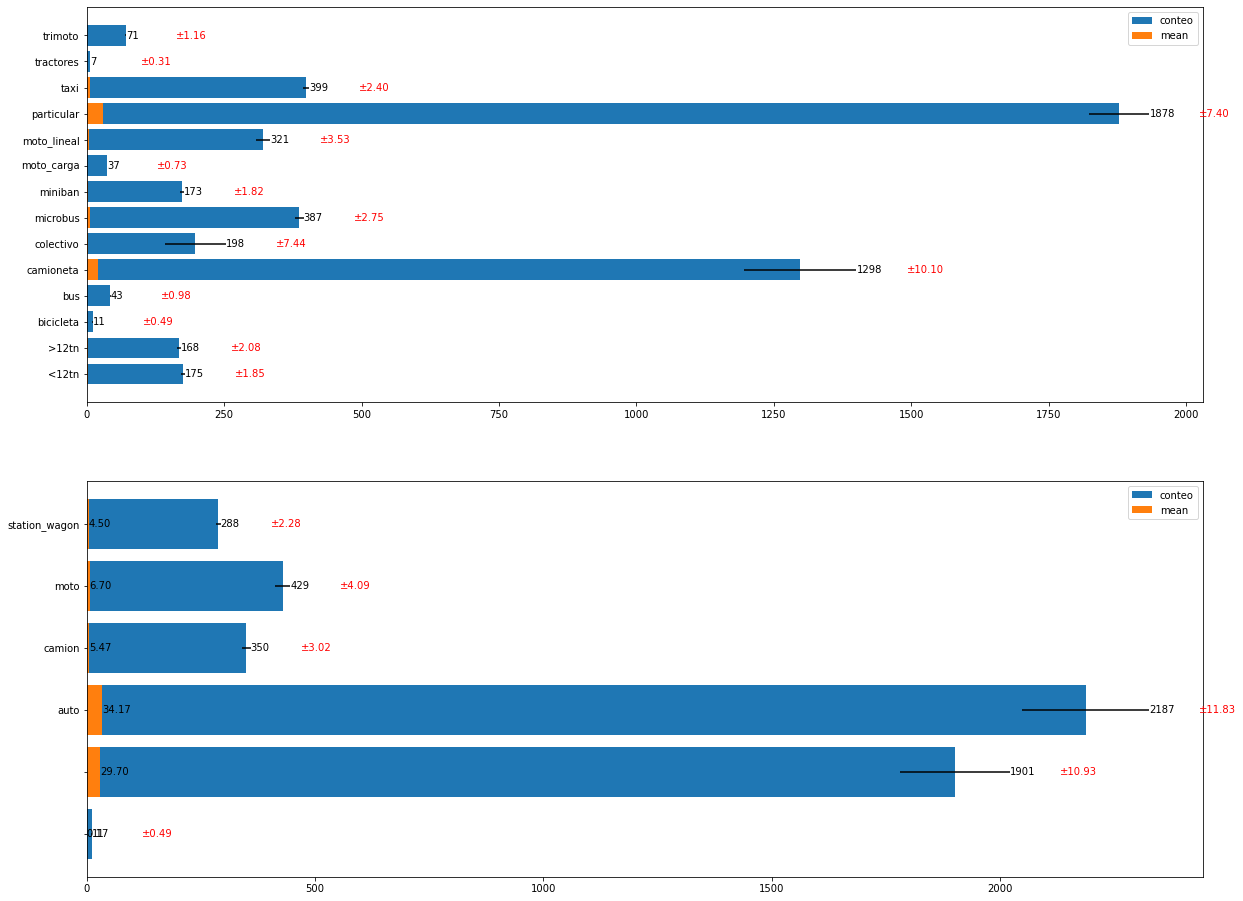

In [20]:
cmap = ListedColormap(sns.color_palette('bright', 2))
fig, ax = plt.subplots(2, 1, figsize=(20,16))
std_1 = data_resampled.groupby(level=1, axis=1).sum().std()
means_1 = data_resampled.groupby(level=1, axis=1).sum().mean()
data_1 = data_resampled.groupby(level=1, axis=1).sum().sum()
# ah1 = ax[0].barh(data_1.index, width=data_1.tolist(), align='center', xerr=std_1**2)
ah1 = ax[0].barh(data_1.index, width=data_1.tolist(), align='center', xerr=std_1**2, label='conteo')
ax[0].bar_label(ah1, fmt='%.0f')
ax[0].bar_label(ah1, labels=['±%.2f' % e for e in std_1.tolist()],
             padding=50 , color='r')
ah1 = ax[0].barh(data_1.index, width=means_1.tolist(), align='center', label='mean')
# ax[0].bar_label(ah1, fmt='%.2f')
ax[0].legend()

std_2 = data_resampled.groupby(level=0, axis=1).sum().std()
means_2 = data_resampled.groupby(level=0, axis=1).sum().mean()
data_2 = data_resampled.groupby(level=0, axis=1).sum().sum()
ah2 = ax[1].barh(data_2.index, width=data_2.tolist(), align='center', xerr=std_2**2, label='conteo')
ax[1].bar_label(ah2, fmt='%.0f')
ax[1].bar_label(ah2, labels=['±%.2f' % e for e in std_2.tolist()],
             padding=50 , color='r')
ah2 = ax[1].barh(data_2.index, width=means_2.tolist(), align='center', label='mean')
ax[1].bar_label(ah2, fmt='%.2f')
ax[1].legend()
fig.savefig(out_dir.getospath('barras.pdf').decode('utf-8'), format='pdf')
plt.show()

In [21]:
def explode_generator(len):
    counter = 0
    for i in range(len):
        yield counter
        counter += 0.008
        # if i % 2:
            # yield 0.1
        # else:
            # yield 0
exploder = list(explode_generator(14))

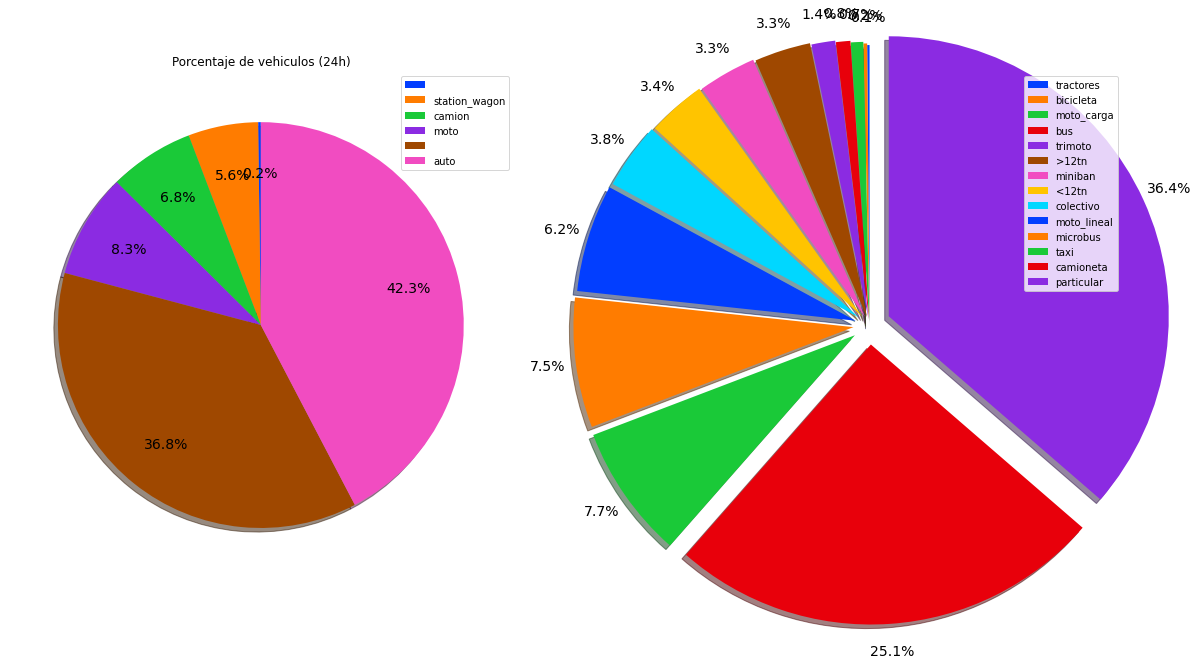

In [22]:
cmap = ListedColormap(sns.color_palette('bright', 7))
fig, ax = plt.subplots(1,2, figsize=(20,12))
fig.patch.set_facecolor('white')
ax[0].set_title("Porcentaje de vehiculos (24h)")
data.groupby(level=0, axis=1).sum().sum().sort_values() \
    .plot.pie(ax=ax[0], autopct='%1.1f%%', startangle=90, colormap=cmap, legend=True, labels=None, pctdistance=.75, labeldistance=1.2, fontsize=14, radius=1.0, shadow=True)
# ax[0].legend('lower left')
cmap = ListedColormap(sns.color_palette('bright', 15))
aaa = data.groupby(level=1, axis=1).sum().sum().sort_values()
aaa \
    .plot.pie(ax=ax[1], autopct='%1.1f%%', startangle=90, colormap=cmap, legend=True, labels=None, pctdistance=1.1, labeldistance=1.2, fontsize=14, radius=1.38, explode=exploder, textprops={'size': 14}, shadow=True)
# ax[1].legend()
ax[0].set_ylabel('')
ax[1].set_ylabel('')
fig.savefig(out_dir.getospath('pasteles.pdf').decode('utf-8'), format='pdf')
plt.show()

In [23]:
plt.close("all")